# Impact of path on trends in an offline DA product: the Last Millennium Reanalysis 

In [1]:
%load_ext autoreload
%autoreload 2
# import the pens package (https://github.com/fzhu2e/pens)
import pens

## Load LMR 2.1 data from a local .nc file

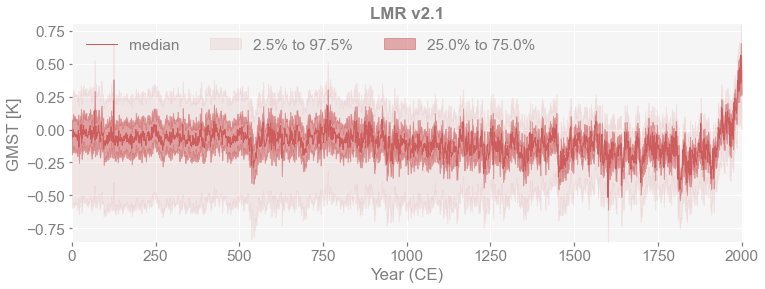

In [2]:
folder = '/Users/julieneg/Documents/Science/Research/LastMillenniumReanalysis/data/LMRv2.1/'
ens = pens.EnsembleTS().load_nc(folder + 'gmt_MCruns_ensemble_full_LMRv2.1.nc', var='gmt')
fig, ax = ens.plot_qs(ylabel='GMST [K]', title='LMR v2.1')

## Define engine for estimating means and trends

The code uses Gaussian kernel density estimation to estimate the distribution of means and trends over various interval lengths. The central question is: _How unusual are the most recent GMST mean and trend?_ 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pyleoclim.utils.filter as flt
import statsmodels.api as sm

def means_and_trends_ensemble(var,segment_length,step,years):
    ''' Calculates the means and trends on an ensemble array
        Uses statsmodels' OLS method

     Inputs:
        var:                2d numpy array [time, ens member]
        segment_length:     # elements in block (integer)
        step:               step size (integer)
        years:              1d numpy array

     Outputs:
        means:      Means of every segment.
        trends:     trends over every segment.
        idxs:       The first and last index of every segment, for record-keeping.
        tm:         median time point of each block

    Author: Julien Emile-Geay, based on code by Michael P. Erb.
    Date: March 8, 2018
    '''
    if var.ndim < 2:
       print("Beef up your ensemble, yo. Ain't got nothing in it")

    n_years, n_ens = var.shape

    n_segments = int(((n_years-segment_length)/step)+1)
    skip_idx = np.remainder(n_years-segment_length,step)  # If the segments don't cover the entire time-span, skip years at the beginning.

    # Initialize vars
    means      = np.empty((n_segments,n_ens))
    trends     = np.empty((n_segments,n_ens))
    tm         = np.empty((n_segments))
    idxs       = np.empty((n_segments,2),dtype=int)

    fc = 1/segment_length #smoothing length

    # Compute the means and trends for every location
    for m in range(n_ens):
        y = var[:,m]
        yl = flt.butterworth(y,fc)

        for k in range(n_segments):
            start_idx = skip_idx+(k*step)
            end_idx   = start_idx+segment_length-1
            # compute block averages
            means[k,m] = np.mean(y[start_idx:end_idx])

            # compute trends with robust fit
            x = years[start_idx:end_idx];  x  = sm.add_constant(x)
            _ , trends[k,m] = sm.OLS(yl[start_idx:end_idx],x).fit().params

            # indices
            if m == 0:
                idxs[k,:] = start_idx,end_idx-1
                tm[k]     = np.median(years[start_idx:end_idx])

    return means, trends, tm, idxs

## Trend Estimation without randomization

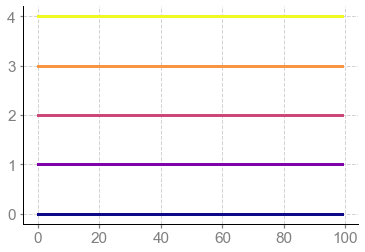

In [4]:
# workshop the color scheme
clr = plt.cm.plasma((np.linspace(0,1,5)))
t = ens.time[0:100]
for i, c in enumerate(clr):
    plt.plot(t,np.sin(2*np.pi*t)+i,color=c,lw=3)

Performing analysis for 10-years blocks
Performing analysis for 25-years blocks
Performing analysis for 50-years blocks
Performing analysis for 100-years blocks


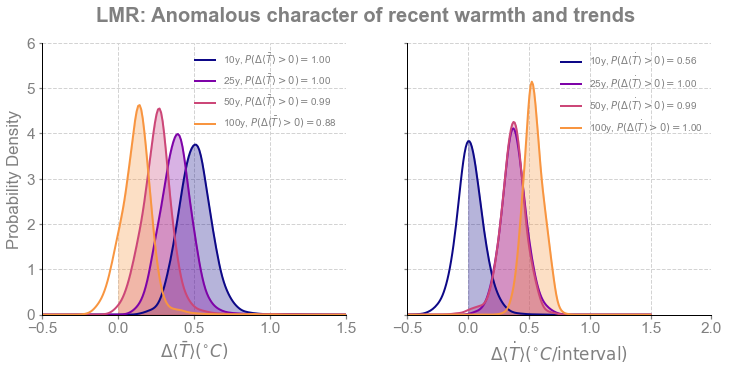

In [15]:
# perform analysis and plot differences.
block_length = [10,25,50,100]; ngrid = 200

# parameters for kernel density estimation
from scipy.stats import gaussian_kde 
xm = np.linspace(-0.5,1.5,ngrid)
xp = xm[xm>=0] # positive x values
bw = 0.2 # set uniform bandwidth
clr = plt.cm.plasma((np.linspace(0,1,5))) # color scheme

fig, axs = plt.subplots(1,2,figsize=(12,5),sharey=True) # define figure axes
axs=axs.reshape(-1) # make axis array 1-dimensional; The argument -1 causes reshape to infer dimensions of the output.
means_trends = {}

for i, Lb in enumerate(block_length):
    print("Performing analysis for "+ str(Lb)+"-years blocks")  
    means, trends, tm, idxs = means_and_trends_ensemble(ens.value,Lb,Lb,ens.time)
    means_trends[str(Lb)] = {}
    means_trends[str(Lb)]['means'] = means
    means_trends[str(Lb)]['trends'] = trends
    means_trends[str(Lb)]['tm'] = tm
    means_trends[str(Lb)]['idxs'] = idxs

    dmeans  = means[-1:] - means[:-1] # difference of means
    dtrends = Lb*(trends[-1:] - trends[:-1]) # difference of trends
    
    # Kernel Density Estimation
    dm_kde = gaussian_kde(dmeans.flatten(),bw_method=0.2)
    dm_prob = dm_kde.integrate_box_1d(0,xm.max()) # estimate probability of positive change
    means_trends[str(Lb)]['dm_probGt0'] = dm_prob
    dt_kde = gaussian_kde(dtrends.flatten(),bw_method=0.2)
    dt_prob = dt_kde.integrate_box_1d(0,xm.max()) # estimate probability of positive change
    means_trends[str(Lb)]['dt_probGt0'] = dt_prob
    
    cutoff_date = str(ens.time[-1]-Lb) # extract date string for cutoff

    xp = xm[xm>=0] # positive x values
    axs[0].fill_between(xp,dm_kde(xp),alpha=0.3, color = clr[i])
    axs[0].plot(xm,dm_kde(xm),linewidth=2,color=clr[i],label=str(Lb)+"y, "+ r'$P(\Delta \langle \bar{T} \rangle > 0)=$'+'{:3.2f}'.format(dm_prob))    
    axs[0].legend(loc='upper right',fontsize=10,shadow=True,frameon=True,fancybox=True)
    axs[0].set_xlim(-0.5,1.5); axs[0].set_ylim(0,6)
    axs[0].set_xlabel(r'$\Delta \langle \bar{T} \rangle ({}^{\circ} C)$');  axs[0].set_ylabel("Probability Density")
    
    axs[1].fill_between(xp,dt_kde(xp),alpha=0.3, color = clr[i])
    axs[1].plot(xm,dt_kde(xm),linewidth=2,color=clr[i],label=str(Lb)+"y, "+ r'$P(\Delta \langle \dot{T} \rangle > 0)=$'+'{:3.2f}'.format(dt_prob))    
    axs[1].legend(loc='upper right',fontsize=10,shadow=True,frameon=True,fancybox=True)
    axs[1].set_xlim(-0.5,2.0); axs[1].set_ylim(0,6)
    axs[1].set_xlabel(r'$\Delta \langle \dot{T} \rangle ({}^{\circ} C/\mathrm{interval})$');
    
fig.suptitle('LMR: Anomalous character of recent warmth and trends',fontweight='bold')    
fig.savefig('WarmthAndTrends_LMR2.1_GMST.pdf',dpi=300, bbox_inches='tight',pad_inches=.3)

The analysis clearly shows that recent decades are exceptional in the context of the Common Era, both in terms of the average temperature $\langle \bar{T} \rangle$ and the rate of global warming $\langle \dot{T} \rangle$. Counting back from CE 2000, the probability that the most recent 10, 25 and 50 years had the warmest average of similar past segments is close to unity. Only for centennial averages does this probability drop below 90%. For rates, the situation is reversed: warming over the decade 1991-2000 is very close to the median decadal warming trend in this dataset, greater than only 56% of past trends. However, the warming rates for all segments longer than 25 years are the highest in nearly all segments and ensemble members. 

## Trend Estimation with randomization

We now repeat this analysis, this time resampling randomly among the ensemble at each time step to capture the inherent variability of offline DA.   

Performing analysis for 10-years blocks
Performing analysis for 25-years blocks
Performing analysis for 50-years blocks
Performing analysis for 100-years blocks


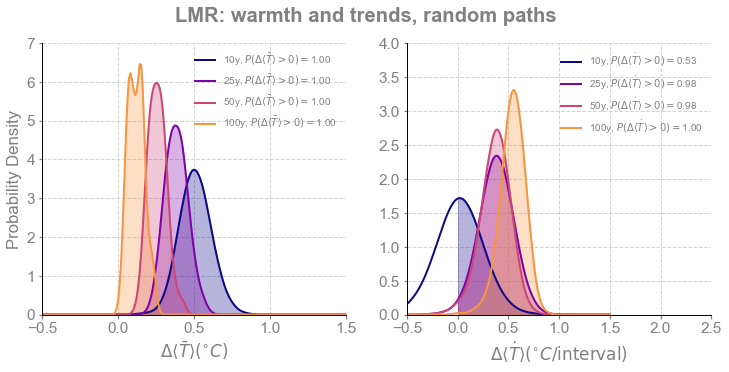

In [18]:
nens = ens.value.shape[1] # number of ensemble members
reshuffle = ens.sample_random(n=nens, seed=2333)

fig, axs = plt.subplots(1,2,figsize=(12,5)) # define figure axes
axs=axs.reshape(-1) # make axis array 1-dimensional; The argument -1 causes reshape to infer dimensions of the output.
means_trends_rnd = {}

for Lb in block_length:
    print("Performing analysis for "+ str(Lb)+"-years blocks")  
    i = block_length.index(Lb) # extract index
    means, trends, tm, idxs = means_and_trends_ensemble(reshuffle.value,Lb,Lb,ens.time)
    means_trends_rnd[str(Lb)] = {}
    means_trends_rnd[str(Lb)]['means'] = means
    means_trends_rnd[str(Lb)]['trends'] = trends
    means_trends_rnd[str(Lb)]['tm'] = tm
    means_trends_rnd[str(Lb)]['idxs'] = idxs

    dmeans  = means[-1:] - means[:-1] # difference of means
    dtrends = Lb*(trends[-1:] - trends[:-1]) # difference of trends, multiplid by interval length
    
    dm_kde = gaussian_kde(dmeans.flatten(),bw_method=0.2)
    dm_prob = dm_kde.integrate_box_1d(0,xm.max())
    means_trends[str(Lb)]['dm_probGt0'] = dm_prob
    dt_kde = gaussian_kde(dtrends.flatten(),bw_method=0.2)
    dt_prob = dt_kde.integrate_box_1d(0,xm.max())
    means_trends[str(Lb)]['dt_probGt0'] = dt_prob
    
    axs[0].fill_between(xp,dm_kde(xp),alpha=0.3, color = clr[i])
    axs[0].plot(xm,dm_kde(xm),linewidth=2,color=clr[i],label=str(Lb)+"y, "+ r'$P(\Delta \langle \bar{T} \rangle > 0)=$'+'{:3.2f}'.format(dm_prob))    
    axs[0].legend(loc='upper right',fontsize=10,shadow=True,frameon=True,fancybox=True)
    axs[0].set_xlim(-0.5,1.5); axs[0].set_ylim(0,7)
    axs[0].set_xlabel(r'$\Delta \langle \bar{T} \rangle ({}^{\circ} C)$');  axs[0].set_ylabel("Probability Density")
    
    axs[1].fill_between(xp,dt_kde(xp),alpha=0.3, color = clr[i])
    axs[1].plot(xm,dt_kde(xm),linewidth=2,color=clr[i],label=str(Lb)+"y, "+ r'$P(\Delta \langle \dot{T} \rangle > 0)=$'+'{:3.2f}'.format(dt_prob))    
    axs[1].legend(loc='upper right',fontsize=10,shadow=True,frameon=True,fancybox=True)
    axs[1].set_xlim(-.5,2.5); axs[1].set_ylim(0,4)
    axs[1].set_xlabel(r'$\Delta \langle \dot{T} \rangle ({}^{\circ} C/\mathrm{interval})$');
    
#plt.subplots_adjust(top=0.8)    
fig.suptitle('LMR: warmth and trends, random paths',fontweight='bold')    
fig.savefig('WarmthAndTrends_LMR2.1_GMST_random_paths.pdf',dpi=300, bbox_inches='tight',pad_inches=.3)

Comments: we can see that considering random paths has a modest effect on this analysis: the basic pictures remains unchanged, and the main change is that the 20th century mean is now uniformly certain to have been the warmest of the Common Era in all ensemble members. The probability distributions for changes in the mean also more concentrated (lower spread) under this treatment. The reasons for this is that impact of resampling is that the ensemble is tightest over the well-sampled instrumental era, so resampling has little effect on those rates or averages. However, for past intervals, the effect of resampling tends to average out for the longest intervals, allowing to estimate the warming signal with slightly more confidence. 

Overall, this is a very minor effect.


## Figure to illustrate the principle

this figure is meant for talks, to explain what is being computed and how it relates to the past. 

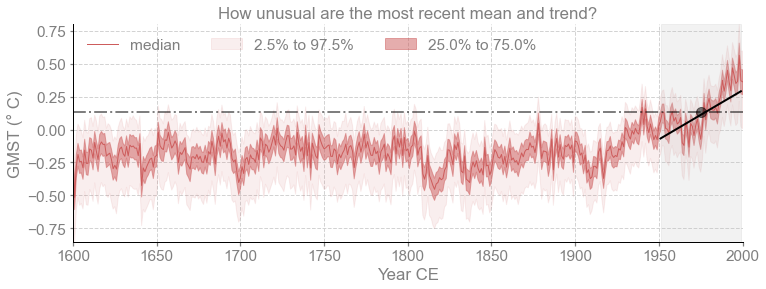

In [11]:
Lb = 50
means = means_trends[str(Lb)]['means']
trends = means_trends[str(Lb)]['trends']
tm = means_trends[str(Lb)]['tm']
idxs = means_trends[str(Lb)]['idxs']

fig, ax = ens.plot_qs(ylabel='GMST [K]', title='LMR v2.1')
ax.set_xlim(1600,2000)
# Plot a dot indicating the most recent mean.
all_idxs = np.arange(idxs[-1,0],idxs[-1,1]+1)
segment_years = ens.time[all_idxs]
dot = ax.scatter(tm[-1],means[-1].mean(),100,color='black',zorder=99,alpha=0.5)
mean_line = ax.axhline(means[-1].mean(),color='black',linewidth=2,ls='-.',alpha=0.5)


slope_segment_values = (all_idxs*trends[-1].mean())-14.65
trend_line, = ax.plot(segment_years,slope_segment_values,color='black',linewidth=2)
ax.axvspan(segment_years[0],segment_years[-1],alpha=0.2,color='silver')
ax.set_xlabel('Year CE'); ax.set_ylabel(u'GMST (\xb0 C)')
ax.set_title("How unusual are the most recent mean and trend?");  
fig.savefig('MostRecentWarmthAndTrends_LMR2.1.pdf',dpi=300, bbox_inches='tight')